In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from scipy.stats import mode
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Random Forest

python(29699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


6-fold CV macro F1-score: 0.6330820929504551
Best parameters (mean val score): {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Mean Validation macro F1-score: 0.6331

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.6133    0.8668    0.7184      1742
           1     0.7464    0.3987    0.5197      1668
           2     0.9066    0.9183    0.9124      4408

    accuracy                         0.7960      7818
   macro avg     0.7554    0.7279    0.7168      7818
weighted avg     0.8071    0.7960    0.7854      7818



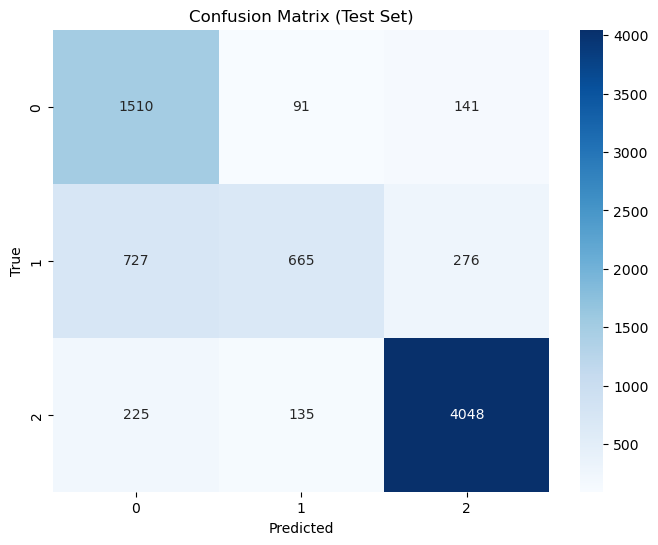

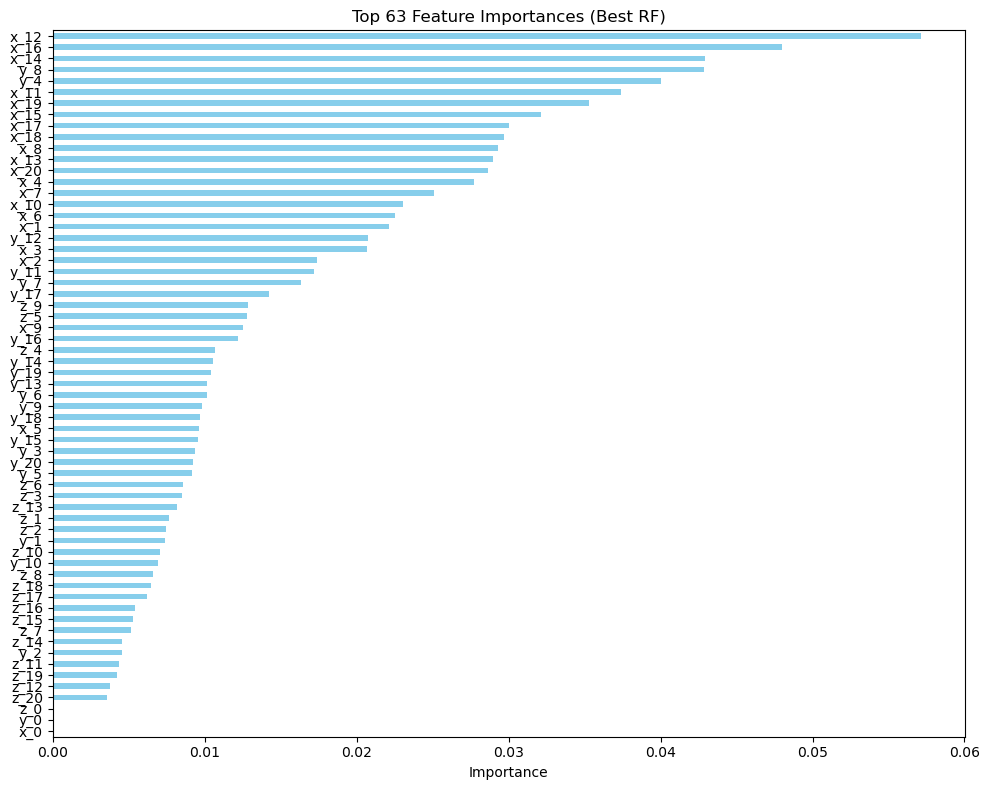

In [32]:
features = all_feature_cols.copy()
target = 'behavior_encoded'
group = 'person_id'

df_rf = df[df[target].isin([0, 1, 2])].copy()
X_rf, y_rf, groups_rf = df_rf[features], df_rf[target], df_rf[group]

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

is_train = groups_rf.isin(train_users)
is_test = groups_rf.isin(test_users)

X_train, y_train = X_rf[is_train], y_rf[is_train]
X_test, y_test = X_rf[is_test], y_rf[is_test]
groups_train = groups_rf[is_train]

best_params = {
    'max_depth': 10,
    'max_features': 'log2',
    'min_samples_leaf': 2,
    'min_samples_split': 15,
    'n_estimators': 100
}

gkf = GroupKFold(n_splits=6)  
fold_scores = []

for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf = RandomForestClassifier(
        **best_params,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    y_val_pred = rf.predict(X_val)
    score = f1_score(y_val, y_val_pred, average='macro')
    fold_scores.append(score)

mean_score = np.mean(fold_scores)
print("6-fold CV macro F1-score:", mean_score)

best_model = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train, y_train)


print("Best parameters (mean val score):", best_params)
print("Mean Validation macro F1-score: {:.4f}".format(mean_score))

y_test_pred = best_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(63).sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Top 63 Feature Importances (Best RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Best parameters (mean val score): {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean Validation macro F1-score: 0.6262

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.5761    0.8754    0.6949      1742
           1     0.7688    0.3609    0.4912      1668
           2     0.9152    0.9111    0.9131      4408

    accuracy                         0.7858      7818
   macro avg     0.7534    0.7158    0.6998      7818
weighted avg     0.8084    0.7858    0.7745      7818



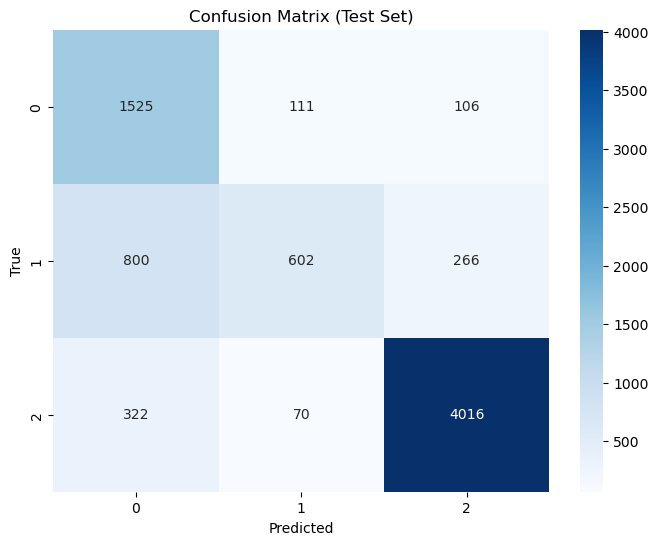

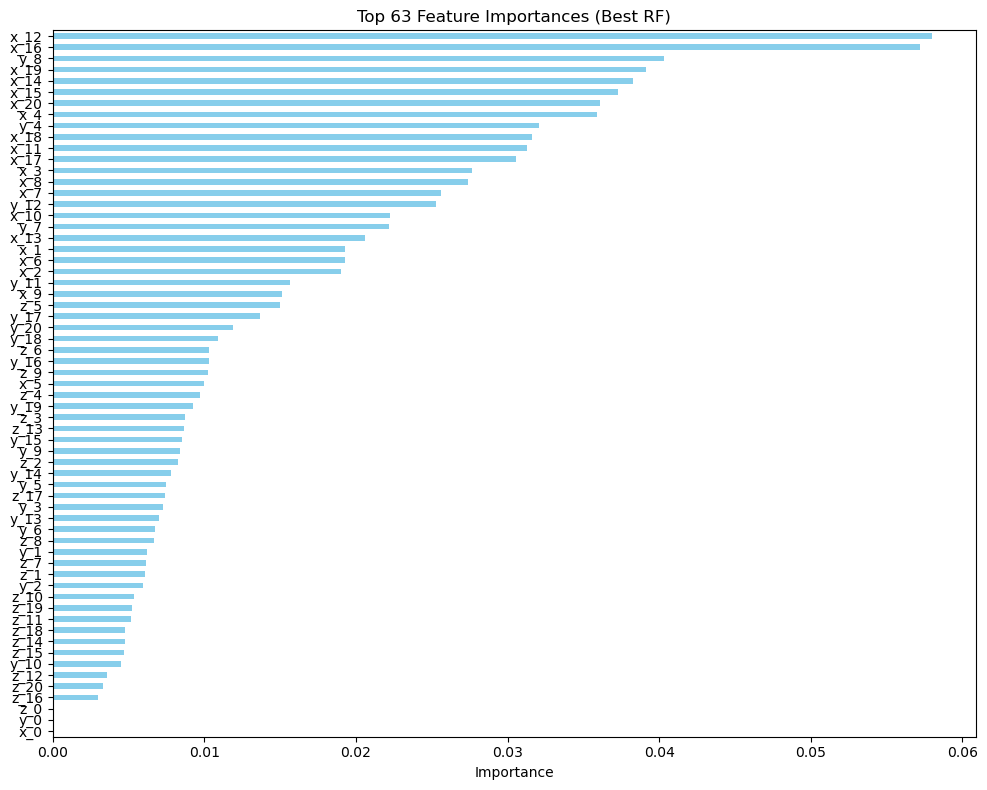

In [23]:
features = all_feature_cols.copy()
target = 'behavior_encoded'
group = 'person_id'

df_rf = df[df[target].isin([0, 1, 2])].copy()
X_rf, y_rf, groups_rf = df_rf[features], df_rf[target], df_rf[group]

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

is_train = groups_rf.isin(train_users)
is_test = groups_rf.isin(test_users)

X_train, y_train = X_rf[is_train], y_rf[is_train]
X_test, y_test = X_rf[is_test], y_rf[is_test]
groups_train = groups_rf[is_train]

param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2']
}

best_score = -np.inf
best_model = None
best_params = None

gkf = GroupKFold(n_splits=6)

for params in ParameterGrid(param_grid):
    fold_scores = []
    
    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf = RandomForestClassifier(
            **params,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_tr, y_tr)
        y_val_pred = rf.predict(X_val)
        score = f1_score(y_val, y_val_pred, average='macro')
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)

    if mean_score > best_score:
        best_score = mean_score
        best_model = rf
        best_params = params

print("Best parameters (mean val score):", best_params)
print("Mean Validation macro F1-score: {:.4f}".format(mean_score))

y_test_pred = best_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(63).sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Top 63 Feature Importances (Best RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [68]:
for cols in feat_imp:
    print(cols)

0.0
0.022148351769270054
0.017402490782805768
0.020662656998543447
0.027736039259428278
0.00965452412088082
0.022516986017172
0.025066104380069024
0.029305760161371062
0.012531113301798229
0.023026145551684526
0.0373729817299917
0.05715164723895369
0.028950425338803317
0.04292374225470204
0.032146097364410146
0.04796130818162481
0.029996989157930528
0.029669836505614843
0.035292927336122444
0.02861981005457124
0.0
0.00740520732308025
0.004549943461208803
0.009372516165934666
0.040017919324119376
0.009150544781220965
0.01012885578696099
0.016371038966348752
0.04286172420549538
0.00984742818150671
0.006921487446023856
0.017217188074158344
0.020715758792903133
0.010181961844876394
0.010555759874060768
0.009562140347523559
0.01219283231038789
0.014231532165640765
0.009701492282334395
0.010432390348699949
0.009209993291712541
0.0
0.007658800360878365
0.007452129662038706
0.00851918627963765
0.010661069344754786
0.012763476143994597
0.008562529542446164
0.005130604193904252
0.006617473587954

## LSTM

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from scipy.stats import mode
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model

In [39]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 1 - Accuracy: 0.8152, Macro F1: 0.7387, F1 Class 0: 0.6715, F1 Class 1: 0.5987, F1 Class 2: 0.9459

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2 - Accuracy: 0.7882, Macro F1: 0.6910, F1 Class 0: 0.7110, F1 Class 1: 0.4343, F1 Class 2: 0.9278

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3 - Accuracy: 0.8139, Macro F1: 0.7313, F1 Class 0: 0.7043, F1 Class 1: 0.5434, F1 Class 2: 0.9462

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4 - Accuracy: 0.8307, Macro F1: 0.7609, F1 Class 0: 0.7112, F1 Class 1: 0.6228, F1 Class 2: 0.9487

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5 - Accuracy: 0.8274, Macro F1: 0.7663, F1 Class 0: 0.7388, F1 Class 1: 0.6226, F1 Class 2: 0.9374


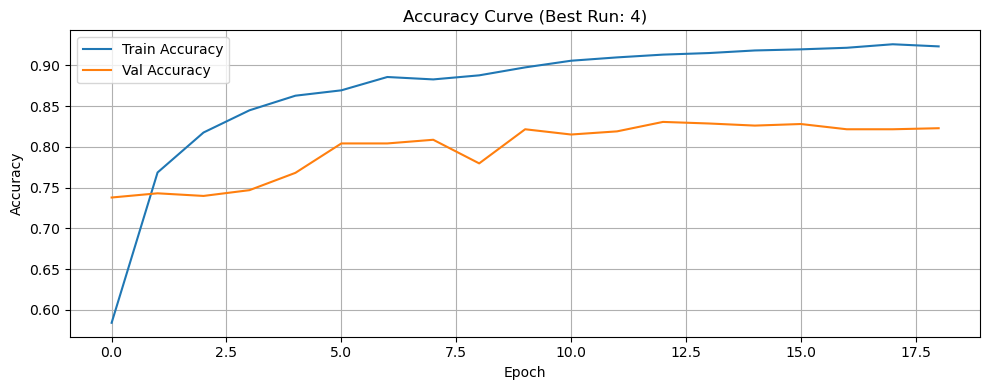

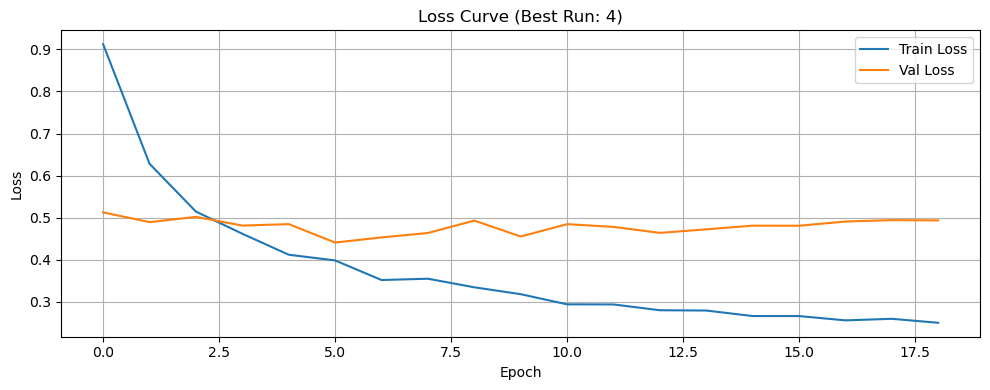


== Confusion Matrix of Best Run (Run 4) ==



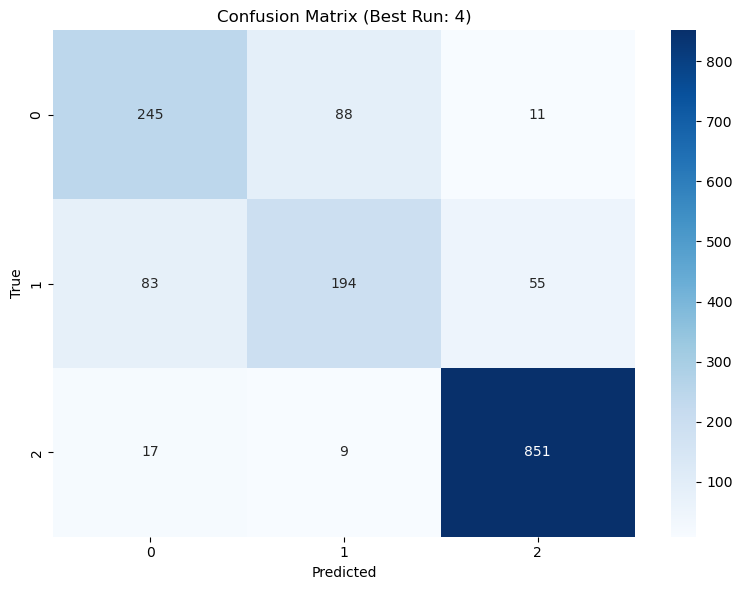

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.815196  0.738720    0.671533    0.598726    0.945901
1     0.788152  0.691018    0.710956    0.434263    0.927835
2     0.813909  0.731312    0.704261    0.543438    0.946237
3     0.830650  0.760896    0.711176    0.622793    0.948718
4     0.827431  0.766278    0.738764    0.622642    0.937429
Mean  0.815068  0.737645    0.707338    0.564372    0.941224
Std   0.014977  0.026742    0.021480    0.071211    0.007705

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.923182,0.801030,0.250123,0.587557
1,0.884035,0.775918,0.362327,0.513250
2,0.904005,0.808113,0.304196,0.470813
3,0.923295,0.822923,0.249541,0.493178
4,0.897424,0.808113,0.333877,0.471904
Mean,0.906388,0.803220,0.300013,0.507341
Std,0.015189,0.015403,0.044908,0.043035


In [42]:
reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [43]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.662327  0.769767  0.707338   344.000000  0.054336  0.085803   
1             0.659529  0.503614  0.564372   332.000000  0.027251  0.115629   
2             0.932105  0.950741  0.941224   877.000000  0.005459  0.019458   
accuracy      0.815068  0.815068  0.815068     0.815068  0.016744  0.016744   
macro avg     0.751320  0.741374  0.737645  1553.000000  0.018895  0.020823   
weighted avg  0.814076  0.815068  0.808853  1553.000000  0.012770  0.016744   

                                  
              f1-score   support  
0             0.024015  0.000000  
1             0.079616  0.000000  
2             0.008614  0.000000  
accuracy      0.016744  0.016744  
macro avg     0.029899  0.000000  
weighted avg  0.021285  0.000000

In [61]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 1 - Accuracy: 0.8062, Macro F1: 0.7353, F1 Class 0: 0.6610, F1 Class 1: 0.6087, F1 Class 2: 0.9364

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2 - Accuracy: 0.8223, Macro F1: 0.7561, F1 Class 0: 0.7519, F1 Class 1: 0.5816, F1 Class 2: 0.9346

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3 - Accuracy: 0.8216, Macro F1: 0.7533, F1 Class 0: 0.7143, F1 Class 1: 0.6029, F1 Class 2: 0.9428

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4 - Accuracy: 0.8397, Macro F1: 0.7822, F1 Class 0: 0.7586, F1 Class 1: 0.6497, F1 Class 2: 0.9381

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5 - Accuracy: 0.8609, Macro F1: 0.8070, F1 Class 0: 0.7985, F1 Class 1: 0.6790, F1 Class 2: 0.9434


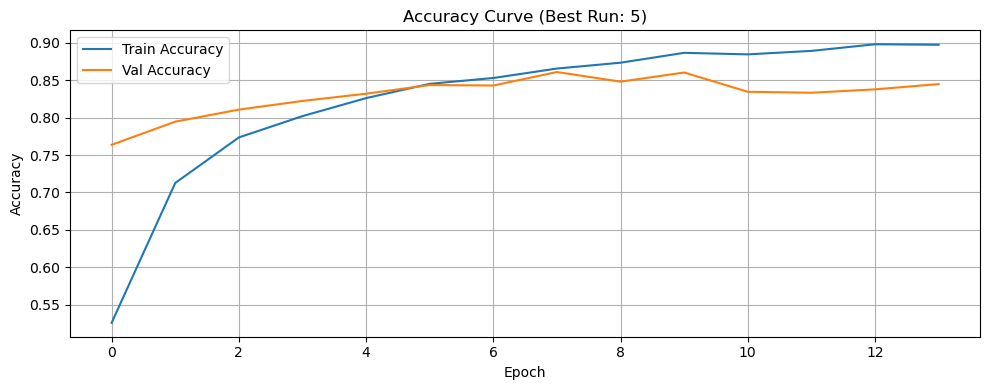

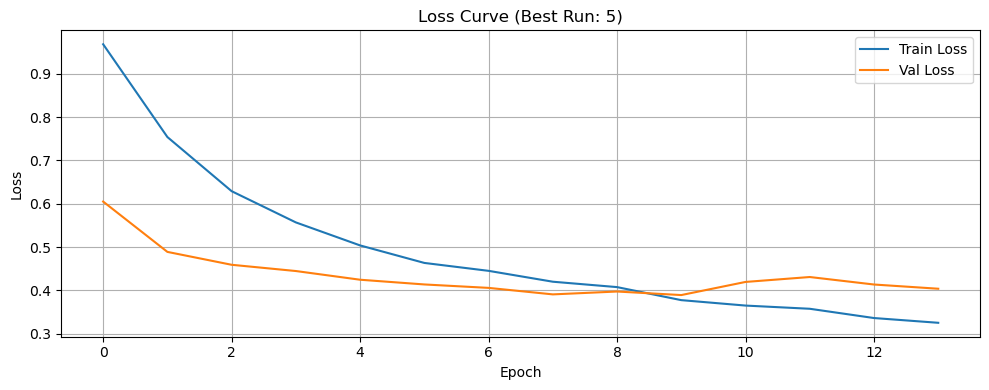


== Confusion Matrix of Best Run (Run 5) ==



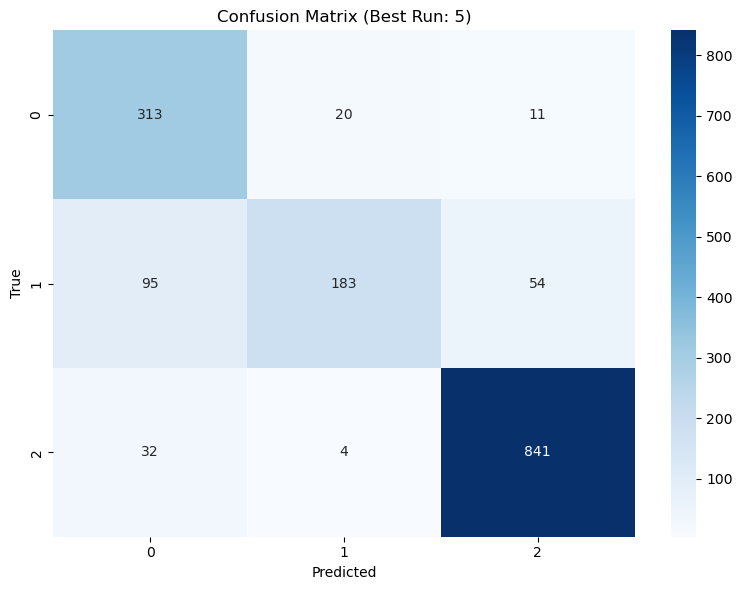

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.806182  0.735343    0.660969    0.608696    0.936364
1     0.822279  0.756068    0.751938    0.581633    0.934633
2     0.821636  0.753311    0.714286    0.602871    0.942776
3     0.839665  0.782157    0.758621    0.649746    0.938103
4     0.860914  0.806953    0.798469    0.679035    0.943354
Mean  0.830135  0.766766    0.736856    0.624396    0.939046
Std   0.018686  0.025039    0.046402    0.035119    0.003465

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.890049,0.803606,0.356524,0.482427
1,0.859412,0.796523,0.441647,0.424971
2,0.881085,0.811333,0.364862,0.446675
3,0.886418,0.815840,0.360191,0.432381
4,0.897311,0.844817,0.325317,0.403889
Mean,0.882855,0.814424,0.369708,0.438068
Std,0.012854,0.016570,0.038558,0.026130


In [62]:
reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [63]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.684581  0.800581  0.736856   344.000000  0.023997  0.092718   
1             0.712445  0.560843  0.624396   332.000000  0.105486  0.029311   
2             0.934558  0.943672  0.939046   877.000000  0.004392  0.011014   
accuracy      0.830135  0.830135  0.830135     0.830135  0.020892  0.020892   
macro avg     0.777194  0.768365  0.766766  1553.000000  0.040808  0.027810   
weighted avg  0.831703  0.830135  0.826994  1553.000000  0.025315  0.020892   

                                  
              f1-score   support  
0             0.051879  0.000000  
1             0.039264  0.000000  
2             0.003874  0.000000  
accuracy      0.020892  0.020892  
macro avg     0.027995  0.000000  
weighted avg  0.019105  0.000000

## BiLSTM


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 1 - Accuracy: 0.8158, Macro F1: 0.7541, F1 Class 0: 0.7064, F1 Class 1: 0.6266, F1 Class 2: 0.9292

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 2 - Accuracy: 0.8313, Macro F1: 0.7727, F1 Class 0: 0.7395, F1 Class 1: 0.6456, F1 Class 2: 0.9331

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 3 - Accuracy: 0.8191, Macro F1: 0.7314, F1 Class 0: 0.7222, F1 Class 1: 0.5269, F1 Class 2: 0.9452

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 4 - Accuracy: 0.8004, Macro F1: 0.7169, F1 Class 0: 0.6857, F1 Class 1: 0.5316, F1 Class 2: 0.9333

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 5 - Accuracy: 0.8158, Macro F1: 0.7441, F1 Class 0: 0.7119, F1 Class 1: 0.5866, F1 Class 2: 0.9340


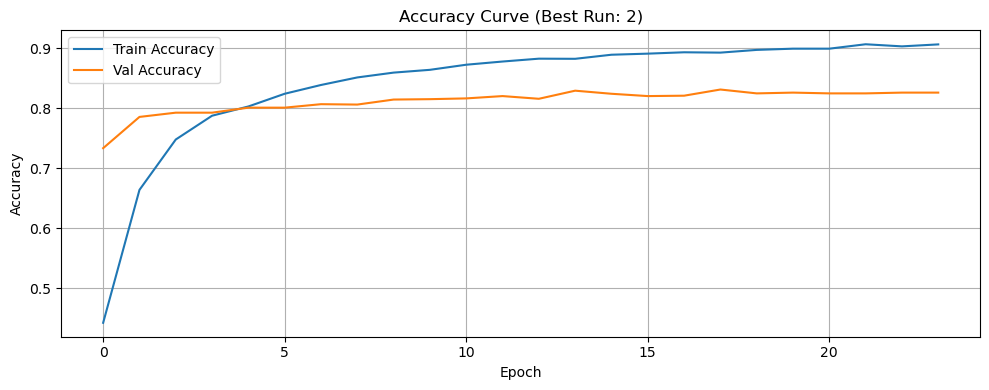

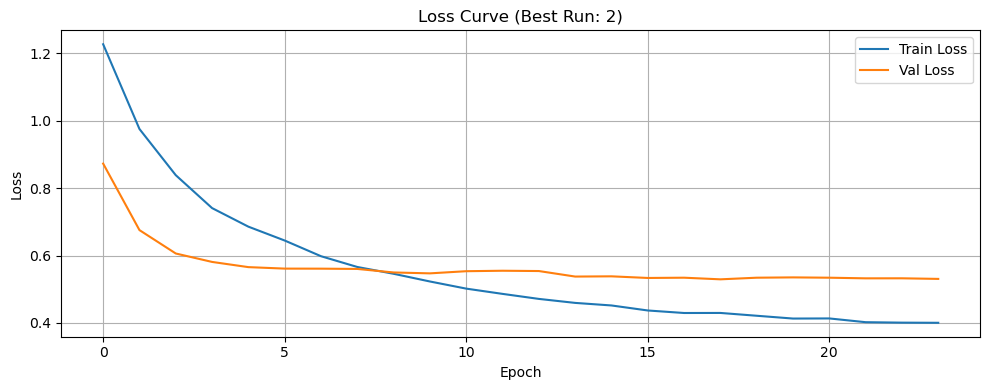


== Confusion Matrix of Best Run (Run 2) ==



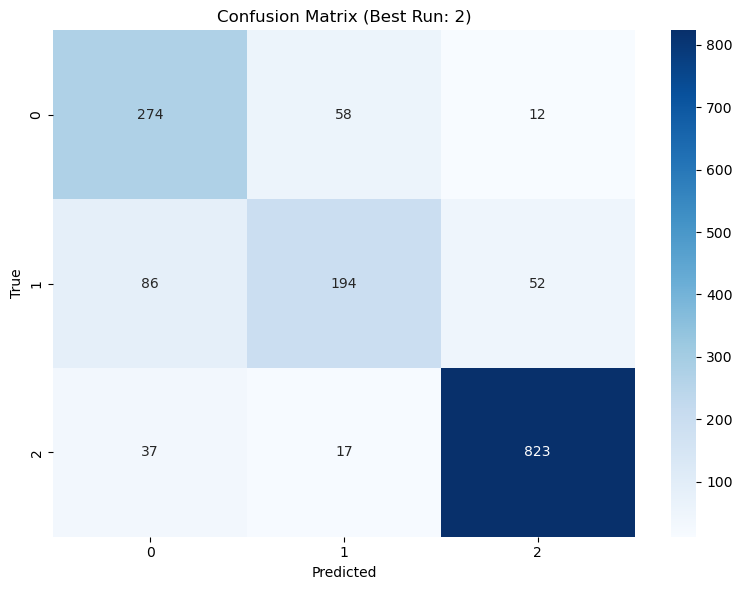

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.815840  0.754059    0.706371    0.626582    0.929224
1     0.831294  0.772746    0.739541    0.645591    0.933107
2     0.819060  0.731430    0.722154    0.526946    0.945190
3     0.800386  0.716873    0.685714    0.531646    0.933259
4     0.815840  0.744149    0.711864    0.586572    0.934010
Mean  0.816484  0.743851    0.713129    0.583467    0.934958
Std   0.009858  0.019086    0.017765    0.048183    0.005381

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.876546,0.811333,0.502179,0.550048
1,0.906615,0.826143,0.400545,0.530647
2,0.892772,0.814552,0.427672,0.532361
3,0.890843,0.789440,0.448113,0.592280
4,0.870078,0.813265,0.513504,0.630333
Mean,0.887371,0.810947,0.458403,0.567134
Std,0.012867,0.011933,0.043244,0.038624


In [44]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, return_sequences=False,
                       dropout=0.4, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  # เก็บ classification_report ของแต่ละรอบในรูปแบบ DataFrame
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = []  # เก็บ classification_report ของแต่ละรอบในรูปแบบ DataFrame
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        # ดึงค่า train/val จาก epoch สุดท้ายที่ใช้จริง
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        # ======== เก็บ confusion matrix ของ best run
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        # ======== เก็บค่าจาก classification_report
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        # ======== เก็บ summary metric ตามเดิม
        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    
    # Summary
    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    # รวม classification report
    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    # ======= Plot best run learning curve =======
    plot_best_run_learning_curve(histories, val_accuracies)

    # ======== Plot confusion matrix ของ best run
    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)


print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [45]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.650713  0.791279  0.713129   344.000000  0.031016  0.043284   
1             0.707363  0.504217  0.583467   332.000000  0.049122  0.086714   
2             0.925623  0.944584  0.934958   877.000000  0.004637  0.013066   
accuracy      0.816484  0.816484  0.816484     0.816484  0.011022  0.011022   
macro avg     0.761233  0.746693  0.743851  1553.000000  0.018485  0.019713   
weighted avg  0.818069  0.816484  0.810680  1553.000000  0.013167  0.011022   

                                  
              f1-score   support  
0             0.019861  0.000000  
1             0.053870  0.000000  
2             0.006016  0.000000  
accuracy      0.011022  0.011022  
macro avg     0.021338  0.000000  
weighted avg  0.013169  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 1 - Accuracy: 0.8403, Macro F1: 0.7922, F1 Class 0: 0.7597, F1 Class 1: 0.6822, F1 Class 2: 0.9347

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 2 - Accuracy: 0.7894, Macro F1: 0.7024, F1 Class 0: 0.6510, F1 Class 1: 0.5191, F1 Class 2: 0.9371

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 3 - Accuracy: 0.8551, Macro F1: 0.7973, F1 Class 0: 0.7485, F1 Class 1: 0.6901, F1 Class 2: 0.9532

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 4 - Accuracy: 0.8429, Macro F1: 0.7825, F1 Class 0: 0.6887, F1 Class 1: 0.7090, F1 Class 2: 0.9499

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 5 - Accuracy: 0.8223, Macro F1: 0.7548, F1 Class 0: 0.7488, F1 Class 1: 0.5850, F1 Class 2: 0.9307


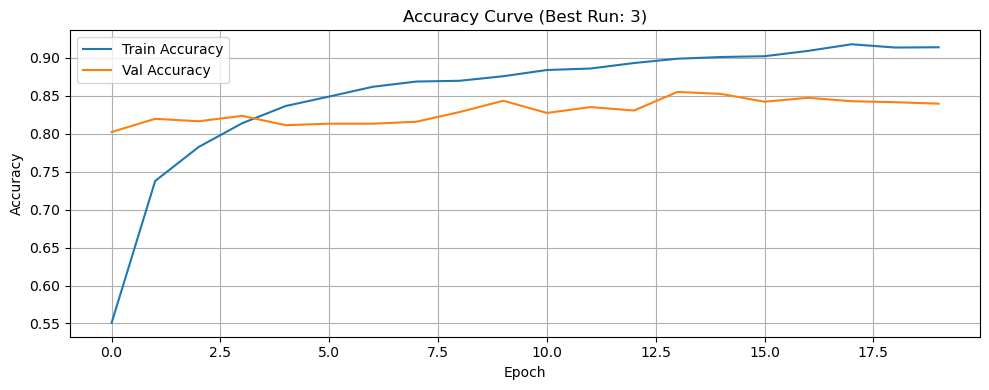

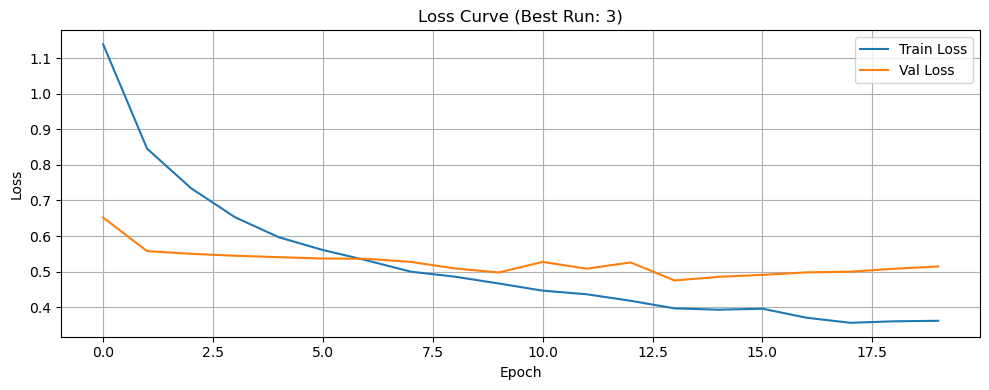


== Confusion Matrix of Best Run (Run 3) ==



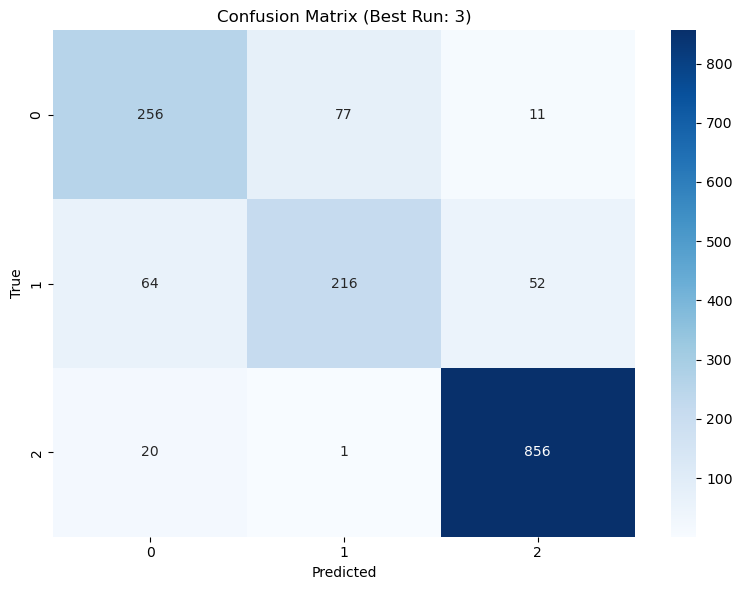

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.840309  0.792211    0.759732    0.682171    0.934732
1     0.789440  0.702416    0.651034    0.519135    0.937079
2     0.855119  0.797288    0.748538    0.690096    0.953229
3     0.842885  0.782541    0.688742    0.708966    0.949916
4     0.822279  0.754839    0.748768    0.585009    0.930738
Mean  0.830006  0.765859    0.719363    0.637075    0.941139
Std   0.022839  0.034948    0.042313    0.072985    0.008819

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.872234,0.794591,0.499794,0.560216
1,0.902190,0.781713,0.390384,0.604020
2,0.913991,0.839665,0.361756,0.514353
3,0.925224,0.834514,0.319755,0.543160
4,0.885056,0.794591,0.446675,0.505464
Mean,0.899739,0.809015,0.403673,0.545443
Std,0.019135,0.023457,0.063347,0.035269


In [71]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, return_sequences=False,
                       dropout=0.4, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [72]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.705534  0.748256  0.719363   344.000000  0.073685  0.109997   
1             0.683125  0.607831  0.637075   332.000000  0.067601  0.129770   
2             0.936639  0.946180  0.941139   877.000000  0.011981  0.025246   
accuracy      0.830006  0.830006  0.830006     0.830006  0.025534  0.025534   
macro avg     0.775100  0.767422  0.765859  1553.000000  0.039336  0.038726   
weighted avg  0.831252  0.830006  0.827011  1553.000000  0.028121  0.025534   

                                  
              f1-score   support  
0             0.047307  0.000000  
1             0.081599  0.000000  
2             0.009860  0.000000  
accuracy      0.025534  0.025534  
macro avg     0.039074  0.000000  
weighted avg  0.027120  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 1 - Accuracy: 0.8667, Macro F1: 0.8300, F1 Class 0: 0.8194, F1 Class 1: 0.7392, F1 Class 2: 0.9313

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 2 - Accuracy: 0.8191, Macro F1: 0.7464, F1 Class 0: 0.7311, F1 Class 1: 0.5730, F1 Class 2: 0.9352

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 3 - Accuracy: 0.8139, Macro F1: 0.7192, F1 Class 0: 0.7460, F1 Class 1: 0.4733, F1 Class 2: 0.9382

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 4 - Accuracy: 0.7888, Macro F1: 0.6952, F1 Class 0: 0.6936, F1 Class 1: 0.4564, F1 Class 2: 0.9355

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 5 - Accuracy: 0.8281, Macro F1: 0.7615, F1 Class 0: 0.7260, F1 Class 1: 0.6172, F1 Class 2: 0.9413


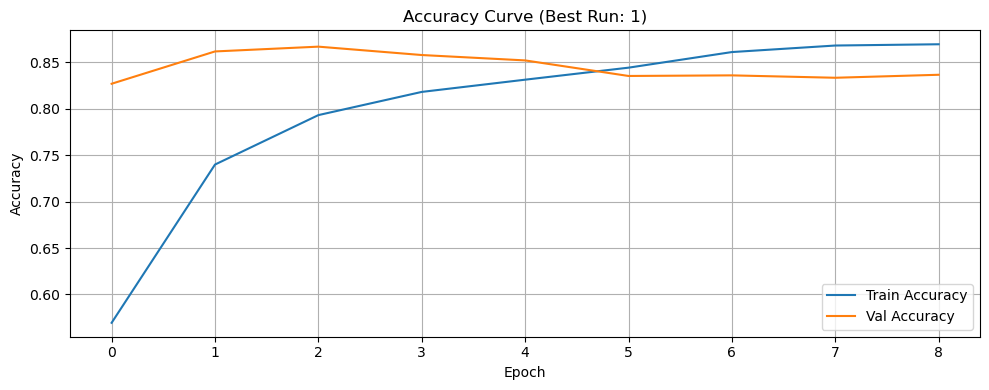

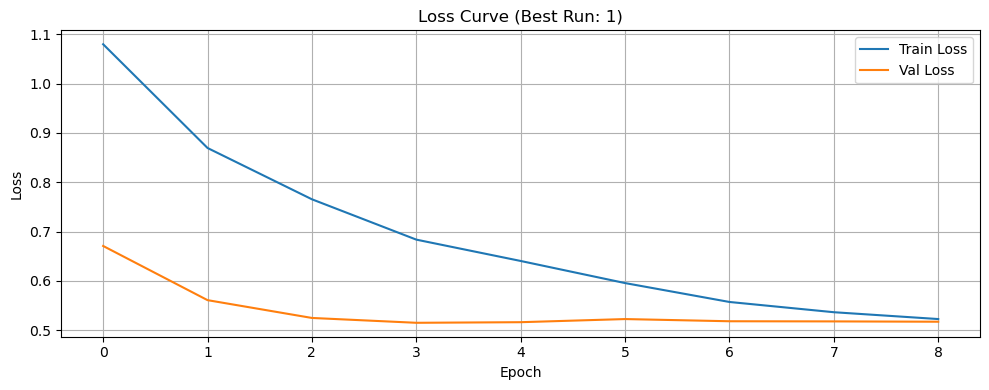


== Confusion Matrix of Best Run (Run 1) ==



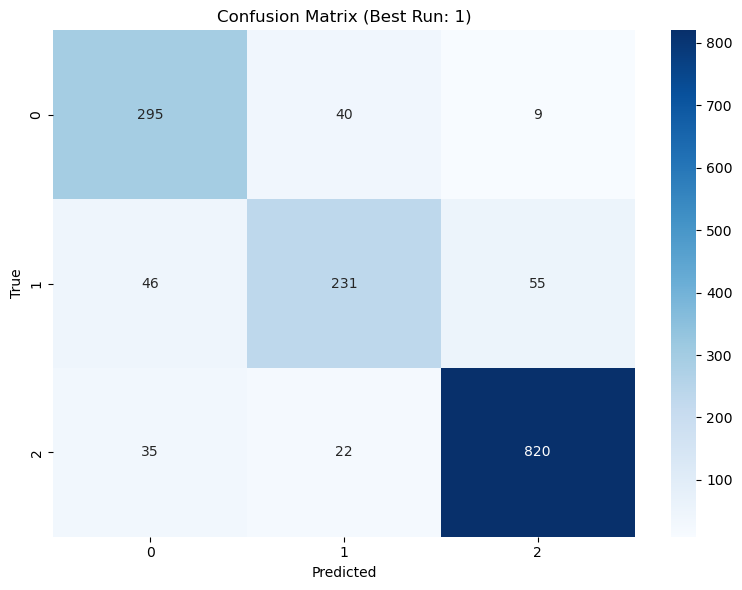

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.866710  0.829978    0.819444    0.739200    0.931289
1     0.819060  0.746423    0.731103    0.573013    0.935154
2     0.813909  0.719172    0.745995    0.473348    0.938174
3     0.788796  0.695165    0.693627    0.456401    0.935465
4     0.828075  0.761519    0.726046    0.617201    0.941309
Mean  0.823310  0.750451    0.743243    0.571832    0.936278
Std   0.025314  0.045822    0.041759    0.103049    0.003338

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.869284,0.836446,0.522724,0.517318
1,0.882333,0.808113,0.478649,0.553808
2,0.874957,0.794591,0.512143,0.558532
3,0.865880,0.772054,0.542210,0.572971
4,0.886304,0.811977,0.477465,0.549595
Mean,0.875752,0.804636,0.506638,0.550444
Std,0.007676,0.021167,0.025254,0.018343


In [69]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, return_sequences=False,
                       dropout=0.3, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [70]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                       Std            \
             precision    recall  f1-score     support precision    recall   
0             0.662795  0.853488  0.743243   344.00000  0.074126  0.061171   
1             0.727119  0.483735  0.571832   332.00000  0.085458  0.145728   
2             0.932591  0.940023  0.936278   877.00000  0.003405  0.007057   
accuracy      0.823310  0.823310  0.823310     0.82331  0.028302  0.028302   
macro avg     0.774168  0.759082  0.750451  1553.00000  0.044098  0.044143   
weighted avg  0.828904  0.823310  0.815608  1553.00000  0.027616  0.028302   

                                  
              f1-score   support  
0             0.046688  0.000000  
1             0.115212  0.000000  
2             0.003732  0.000000  
accuracy      0.028302  0.028302  
macro avg     0.051230  0.000000  
weighted avg  0.032597  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 1 - Accuracy: 0.8519, Macro F1: 0.7977, F1 Class 0: 0.7572, F1 Class 1: 0.6915, F1 Class 2: 0.9444

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 2 - Accuracy: 0.8210, Macro F1: 0.7478, F1 Class 0: 0.7099, F1 Class 1: 0.5906, F1 Class 2: 0.9429

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Run 3 - Accuracy: 0.8410, Macro F1: 0.7778, F1 Class 0: 0.7497, F1 Class 1: 0.6392, F1 Class 2: 0.9445

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 4 - Accuracy: 0.8146, Macro F1: 0.7341, F1 Class 0: 0.6465, F1 Class 1: 0.6021, F1 Class 2: 0.9538

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 5 - Accuracy: 0.8171, Macro F1: 0.7446, F1 Class 0: 0.7289, F1 Class 1: 0.5689, F1 Class 2: 0.9361


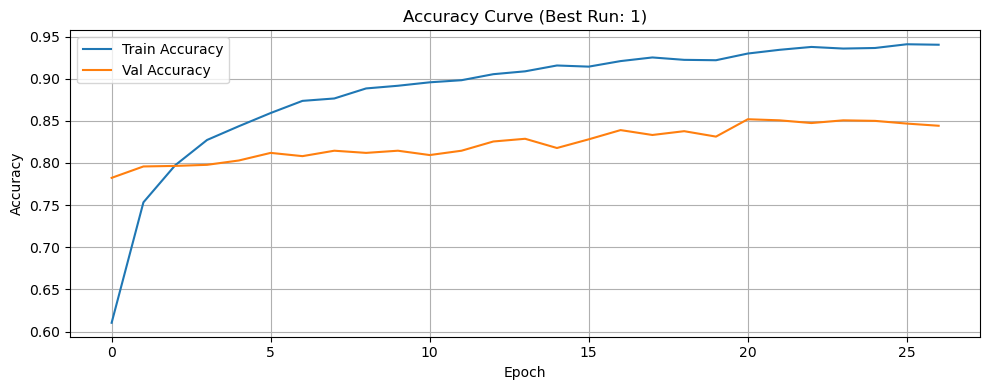

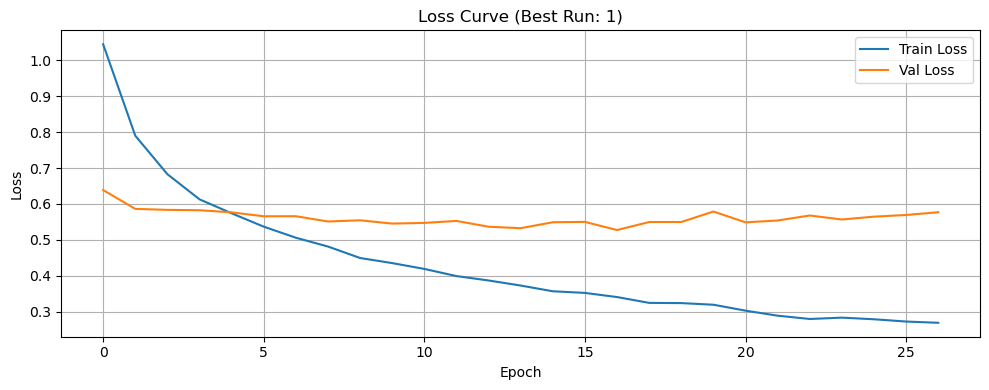


== Confusion Matrix of Best Run (Run 1) ==



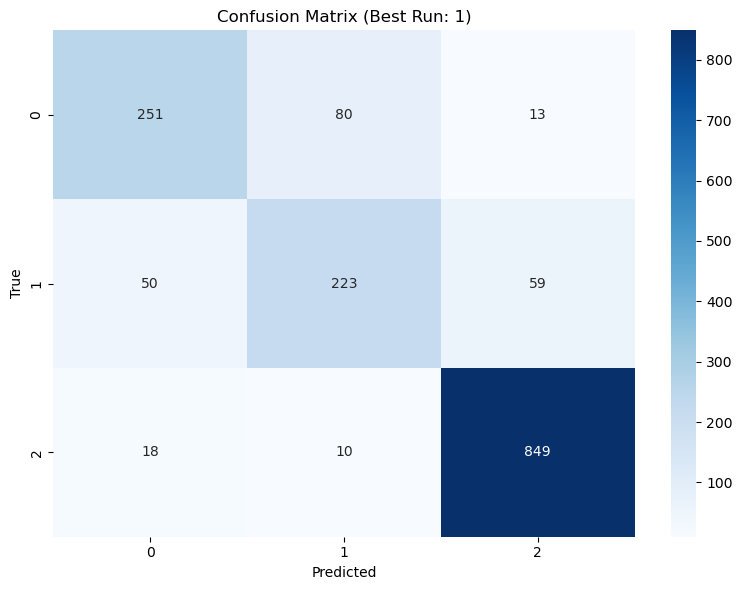

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.851900  0.797673    0.757164    0.691473    0.944383
1     0.820992  0.747813    0.709945    0.590604    0.942889
2     0.840953  0.777792    0.749662    0.639175    0.944538
3     0.814552  0.734122    0.646497    0.602056    0.953812
4     0.817128  0.744632    0.728878    0.568873    0.936146
Mean  0.829105  0.760406    0.718429    0.618436    0.944353
Std   0.014704  0.023619    0.039576    0.043044    0.005639

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.940315,0.844173,0.268647,0.576834
1,0.924316,0.813265,0.338487,0.581365
2,0.910814,0.825499,0.389120,0.543316
3,0.918076,0.813909,0.356447,0.560470
4,0.884489,0.794591,0.454814,0.534199
Mean,0.915602,0.818287,0.361503,0.559237
Std,0.018351,0.016297,0.061069,0.018337


In [73]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, return_sequences=False,
                       dropout=0.3, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [74]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.704571  0.742442  0.718429   344.000000  0.053366  0.096009   
1             0.682192  0.571687  0.618436   332.000000  0.059786  0.075102   
2             0.928840  0.960547  0.944353   877.000000  0.005396  0.015247   
accuracy      0.829105  0.829105  0.829105     0.829105  0.016439  0.016439   
macro avg     0.771868  0.758225  0.760406  1553.000000  0.026146  0.024461   
weighted avg  0.826434  0.829105  0.824635  1553.000000  0.015833  0.016439   

                                  
              f1-score   support  
0             0.044247  0.000000  
1             0.048125  0.000000  
2             0.006305  0.000000  
accuracy      0.016439  0.016439  
macro avg     0.026407  0.000000  
weighted avg  0.017013  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 1 - Accuracy: 0.8558, Macro F1: 0.7990, F1 Class 0: 0.7543, F1 Class 1: 0.6909, F1 Class 2: 0.9519

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Run 2 - Accuracy: 0.8133, Macro F1: 0.7340, F1 Class 0: 0.6608, F1 Class 1: 0.5873, F1 Class 2: 0.9539

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 3 - Accuracy: 0.8339, Macro F1: 0.7629, F1 Class 0: 0.6975, F1 Class 1: 0.6386, F1 Class 2: 0.9526

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Run 4 - Accuracy: 0.8384, Macro F1: 0.7711, F1 Class 0: 0.7094, F1 Class 1: 0.6506, F1 Class 2: 0.9534

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Run 5 - Accuracy: 0.8339, Macro F1: 0.7634, F1 Class 0: 0.7578, F1 Class 1: 0.5865, F1 Class 2: 0.9460


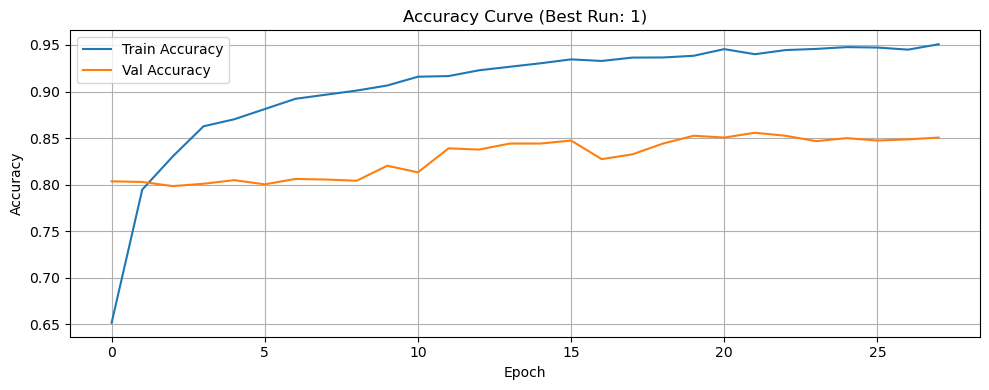

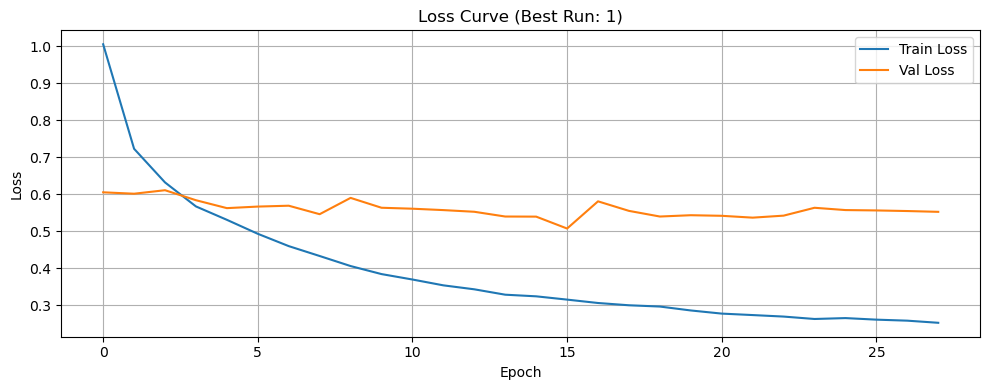


== Confusion Matrix of Best Run (Run 1) ==



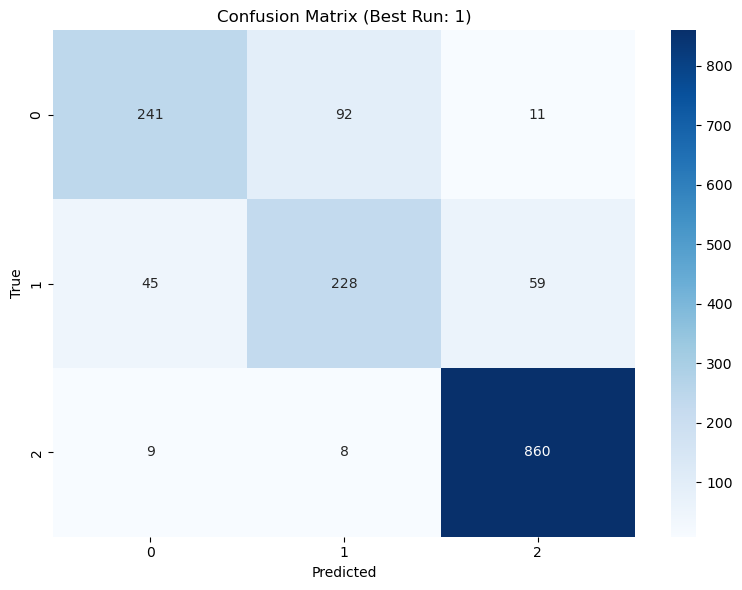

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.855763  0.799022    0.754304    0.690909    0.951854
1     0.813265  0.734000    0.660793    0.587326    0.953881
2     0.833870  0.762866    0.697452    0.638554    0.952591
3     0.838377  0.771121    0.709375    0.650602    0.953385
4     0.833870  0.763412    0.757794    0.586466    0.945977
Mean  0.835029  0.766084    0.715944    0.630772    0.951538
Std   0.013546  0.020771    0.036468    0.039802    0.002865

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.950755,0.850612,0.251903,0.552141
1,0.923068,0.808113,0.369586,0.654574
2,0.941904,0.817772,0.287142,0.675732
3,0.935096,0.824211,0.320601,0.590868
4,0.891524,0.815840,0.456687,0.512411
Mean,0.928469,0.823310,0.337184,0.597145
Std,0.020568,0.014585,0.071250,0.061186


In [78]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False,
                       dropout=0.3, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [79]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.733504  0.713953  0.715944   344.000000  0.073621  0.116779   
1             0.673491  0.603614  0.630772   332.000000  0.068009  0.085449   
2             0.934060  0.970125  0.951538   877.000000  0.013172  0.018967   
accuracy      0.835029  0.835029  0.835029     0.835029  0.015145  0.015145   
macro avg     0.780352  0.762564  0.766084  1553.000000  0.027557  0.022137   
weighted avg  0.833931  0.835029  0.830779  1553.000000  0.017396  0.015145   

                                  
              f1-score   support  
0             0.040773  0.000000  
1             0.044500  0.000000  
2             0.003203  0.000000  
accuracy      0.015145  0.015145  
macro avg     0.023223  0.000000  
weighted avg  0.015001  0.000000

## CNN-BiLSTM


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 1 - Accuracy: 0.8641, Macro F1: 0.7965, F1 Class 0: 0.7863, F1 Class 1: 0.6369, F1 Class 2: 0.9661

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 2 - Accuracy: 0.9002, Macro F1: 0.8592, F1 Class 0: 0.8420, F1 Class 1: 0.7679, F1 Class 2: 0.9676

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 3 - Accuracy: 0.8783, Macro F1: 0.8299, F1 Class 0: 0.7739, F1 Class 1: 0.7521, F1 Class 2: 0.9637

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 4 - Accuracy: 0.8622, Macro F1: 0.7974, F1 Class 0: 0.7824, F1 Class 1: 0.6430, F1 Class 2: 0.9667

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 5 - Accuracy: 0.8371, Macro F1: 0.7681, F1 Class 0: 0.7551, F1 Class 1: 0.5993, F1 Class 2: 0.9499


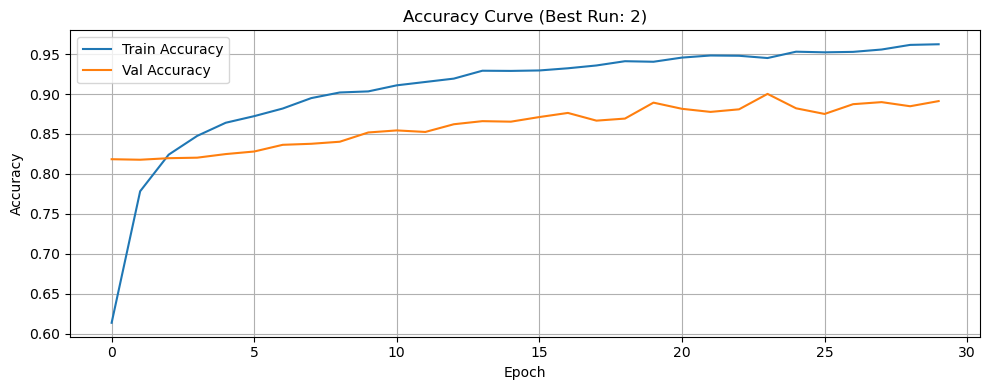

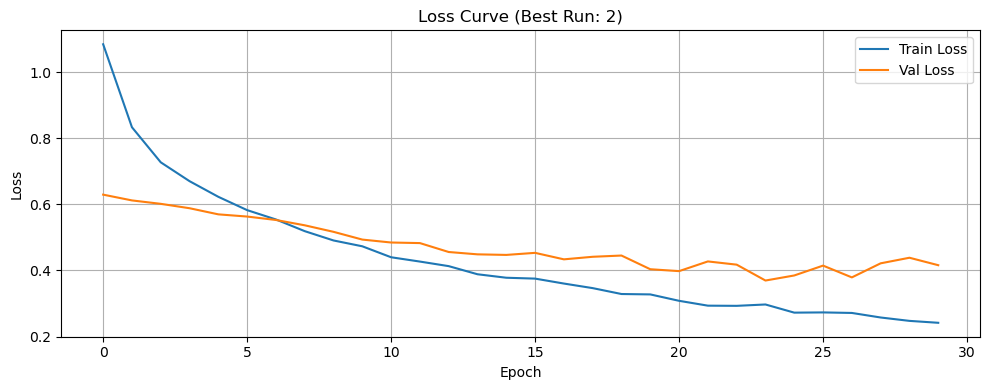


== Confusion Matrix of Best Run (Run 2) ==



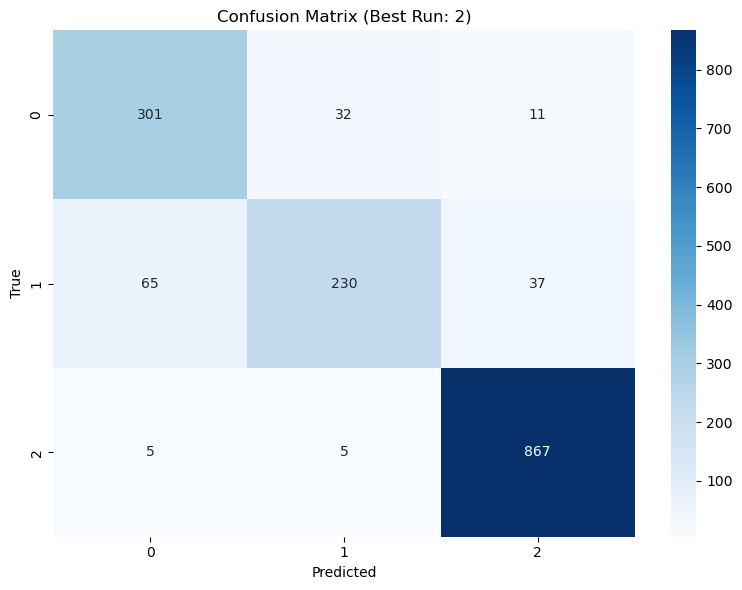

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.864134  0.796453    0.786325    0.636893    0.966140
1     0.900193  0.859180    0.841958    0.767947    0.967634
2     0.878300  0.829889    0.773869    0.752089    0.963707
3     0.862202  0.797351    0.782383    0.642984    0.966685
4     0.837090  0.768112    0.755102    0.599291    0.949943
Mean  0.868384  0.810197    0.787928    0.679841    0.962822
Std   0.020716  0.031344    0.029078    0.067340    0.006569

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.929422,0.842885,0.380190,0.528996
1,0.962328,0.891178,0.241717,0.415886
2,0.958811,0.858339,0.253374,0.513046
3,0.947351,0.855119,0.303264,0.483339
4,0.928174,0.828075,0.396646,0.572907
Mean,0.945217,0.855119,0.315038,0.502835
Std,0.014297,0.020937,0.063595,0.052228


In [15]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, return_sequences=False,
                           dropout=0.3, recurrent_dropout=0.2,
                           kernel_regularizer=l2(0.001)))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [60]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.763612  0.841279  0.797295   344.000000  0.039529  0.080524   
1             0.783398  0.626506  0.691421   332.000000  0.070684  0.071500   
2             0.950647  0.979019  0.964612   877.000000  0.005633  0.005504   
accuracy      0.873149  0.873149  0.873149     0.873149  0.011786  0.011786   
macro avg     0.832552  0.815601  0.817776  1553.000000  0.019195  0.016494   
weighted avg  0.873463  0.873149  0.869147  1553.000000  0.013527  0.011786   

                                  
              f1-score   support  
0             0.025241  0.000000  
1             0.031514  0.000000  
2             0.003948  0.000000  
accuracy      0.011786  0.011786  
macro avg     0.016385  0.000000  
weighted avg  0.011794  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 1 - Accuracy: 0.8667, Macro F1: 0.8126, F1 Class 0: 0.7492, F1 Class 1: 0.7220, F1 Class 2: 0.9666

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 2 - Accuracy: 0.8532, Macro F1: 0.7841, F1 Class 0: 0.7808, F1 Class 1: 0.6108, F1 Class 2: 0.9607

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 3 - Accuracy: 0.8970, Macro F1: 0.8580, F1 Class 0: 0.8235, F1 Class 1: 0.7836, F1 Class 2: 0.9670

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Run 4 - Accuracy: 0.8648, Macro F1: 0.8087, F1 Class 0: 0.7528, F1 Class 1: 0.7124, F1 Class 2: 0.9611

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 5 - Accuracy: 0.8622, Macro F1: 0.7941, F1 Class 0: 0.7734, F1 Class 1: 0.6380, F1 Class 2: 0.9708


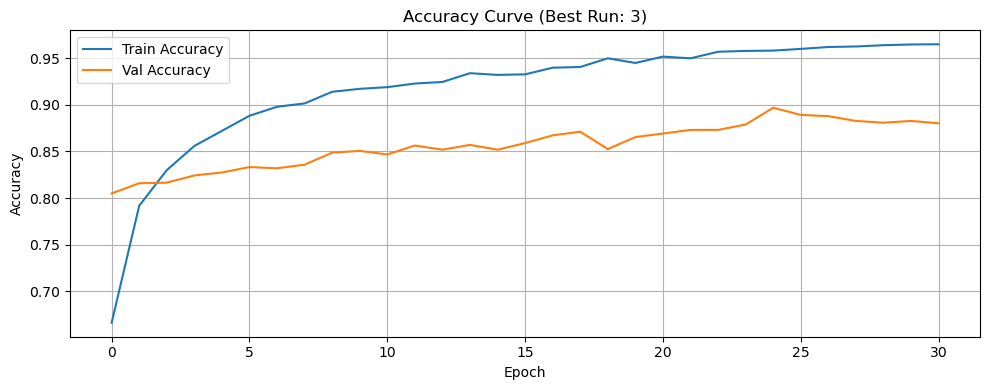

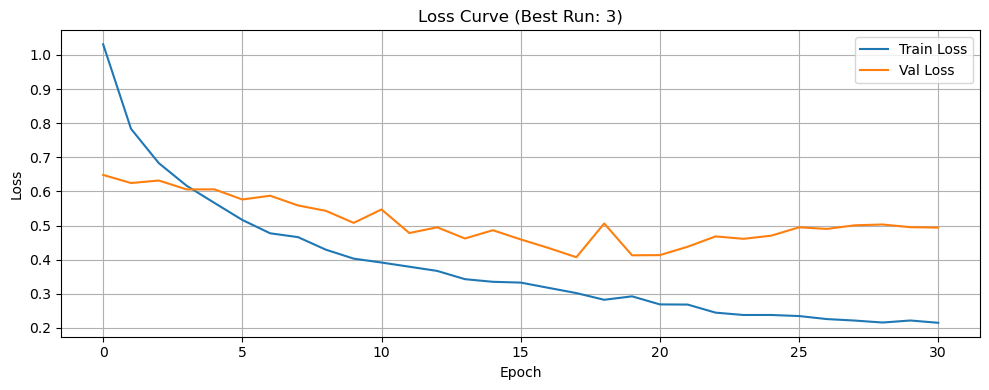


== Confusion Matrix of Best Run (Run 3) ==



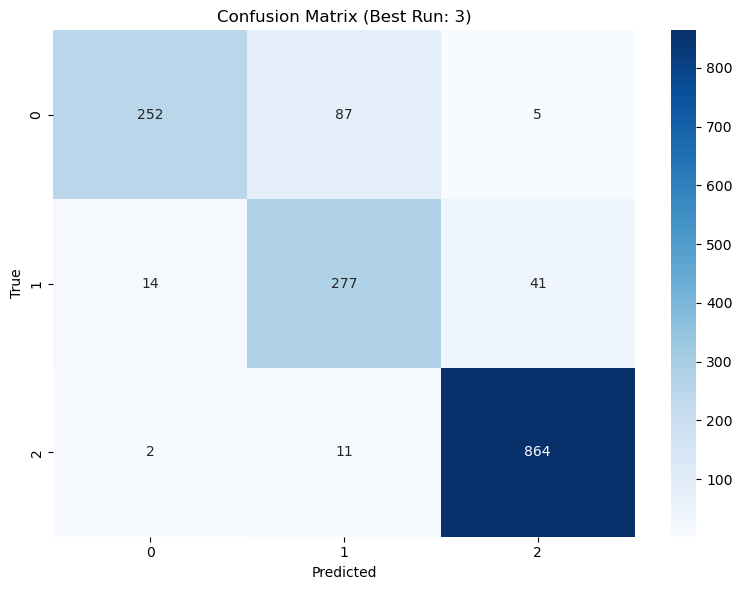

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.866710  0.812596    0.749235    0.721980    0.966572
1     0.853187  0.784106    0.780788    0.610801    0.960729
2     0.896974  0.858035    0.823529    0.783593    0.966984
3     0.864778  0.808746    0.752756    0.712370    0.961111
4     0.862202  0.794072    0.773438    0.637993    0.970787
Mean  0.868770  0.811511    0.775949    0.693347    0.965236
Std   0.014843  0.025411    0.026628    0.061974    0.003820

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.950074,0.860270,0.295487,0.506807
1,0.933167,0.851256,0.335172,0.471860
2,0.965165,0.880232,0.215237,0.494122
3,0.966527,0.846748,0.218858,0.546668
4,0.948599,0.846748,0.273381,0.495255
Mean,0.952706,0.857051,0.267627,0.502942
Std,0.012262,0.012598,0.045814,0.024617


In [18]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, return_sequences=False,
                           dropout=0.3, recurrent_dropout=0.2,
                           kernel_regularizer=l2(0.001)))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [19]:
print("\n== Class-wise Report Summary ==")
report_summary


== Class-wise Report Summary ==


Mean                                       Std            \
             precision    recall  f1-score     support precision    recall   
0             0.785950  0.784884  0.775949   344.00000  0.105111  0.101203   
1             0.745977  0.666265  0.693347   332.00000  0.046445  0.145133   
2             0.952620  0.978335  0.965236   877.00000  0.009642  0.010543   
accuracy      0.868770  0.868770  0.868770     0.86877  0.016595  0.016595   
macro avg     0.828182  0.809828  0.811511  1553.00000  0.027007  0.023874   
weighted avg  0.871525  0.868770  0.865184  1553.00000  0.017342  0.016595   

                                  
              f1-score   support  
0             0.029771  0.000000  
1             0.069289  0.000000  
2             0.004271  0.000000  
accuracy      0.016595  0.016595  
macro avg     0.028410  0.000000  
weighted avg  0.018799  0.000000

In [14]:
train_df = df[df['person_id'].isin(train_users)]
test_df  = df[df['person_id'].isin(test_users)]

print("== Train size ==", len(train_df))
print("== Test size  ==", len(test_df))

print("\n== Train per gesture ==")
print(train_df.groupby('behavior_encoded').size())

print("\n== Test per gesture ==")
print(test_df.groupby('behavior_encoded').size())

print("\n== Train per user per gesture ==")
print(train_df.groupby(['person_id','behavior_encoded']).size())

print("\n== Test per user per gesture ==")
print(test_df.groupby(['person_id','behavior_encoded']).size())

== Train size == 44222
== Test size  == 7818

== Train per gesture ==
behavior_encoded
0     5606
1    14710
2    23906
dtype: int64

== Test per gesture ==
behavior_encoded
0    1742
1    1668
2    4408
dtype: int64

== Train per user per gesture ==
person_id  behavior_encoded
user1      0                   1815
           1                   5016
           2                   3670
user3      0                    866
           1                   2428
           2                   6116
user4      0                   1860
           1                   3174
           2                   5516
user5      0                    303
           1                   1773
           2                   3576
user6      0                    420
           1                   1699
           2                   3737
user7      0                    342
           1                    620
           2                   1291
dtype: int64

== Test per user per gesture ==
person_id  behavior_encoded